# Robot Localization

This code is for the multi-robot localization experiment in the SVBP paper ([Pavlasek et al., 2024](https://progress.eecs.umich.edu/projects/stein-bp/)).

It shows the implementation for both the baseline (Particle Belief Propagation, Ihler & McAllester, 2009) and SVBP.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import time
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch_bp.bp as bp
import torch_bp.distributions as dist

from torch_bp.graph import factors, MRFGraph
from torch_bp.util.multi_robot import MultiRobot
from torch_bp.util.plotting import plot_dists, plot_graph, plot_particles
from torch_bp.inference.kernels import RBFMedianKernel

## Problem Setup

We will create a multi-robot system where the robots get the distance to neighbouring robots and an observation. The observation is a mixture of Gaussians, simulating a multi-modal observation function which might be seen in an environment with symmetries.

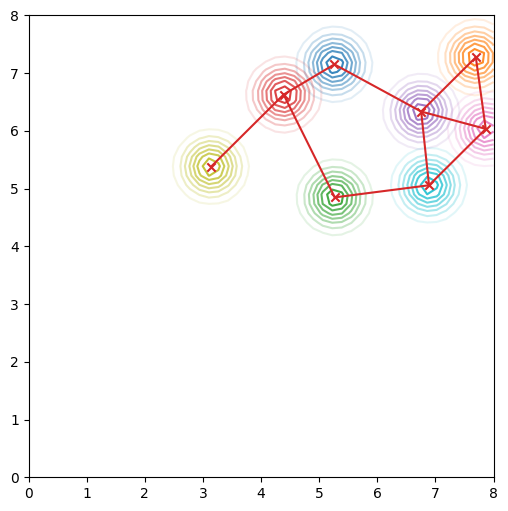

In [3]:
N = 8                # Number of robots.
RADIUS = 2           # Communication radius between robots.
LIMS = [0, 8, 0, 8]  # Environment limits.
OBS_SIGMA = 0.1      # Standard deviation of the observation likelihood.
PAIR_ALPHA = 1       # Coefficient for the pairwise likelihood.
TENSOR_KWARGS = {"dtype": torch.float, "device": "cpu"}

# Create the multi-robot graph. This will do some helpful things like make sure
# the graph is connected and the robots are placed reasonably. It doesn't do
# this perfectly, so you can rerun this for a new environment if needed.
robots = MultiRobot(N, LIMS, radius=RADIUS)

# The edge factors encourage the distance between robots to be equal to the
# measured distances. Here the measurements of the edge distances are the true
# distances between communicating robots.
edge_factors = [factors.DistancePairwiseFactor(e_len, alpha=PAIR_ALPHA) for e_len in robots.edge_lens]

# Create the graph object and some node positions, for visualization. We have
# not defined the observations yet.
g = MRFGraph(N, robots.edges, edge_factors=edge_factors)
node_obs = [dist.Gaussian(robots.pos[i, :], OBS_SIGMA * torch.eye(2), **TENSOR_KWARGS) for i in range(g.N)]

plt.figure(figsize=(6, 6))
plot_dists(plt.gca(), node_obs, LIMS)
plot_graph(plt.gca(), robots.pos, g)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

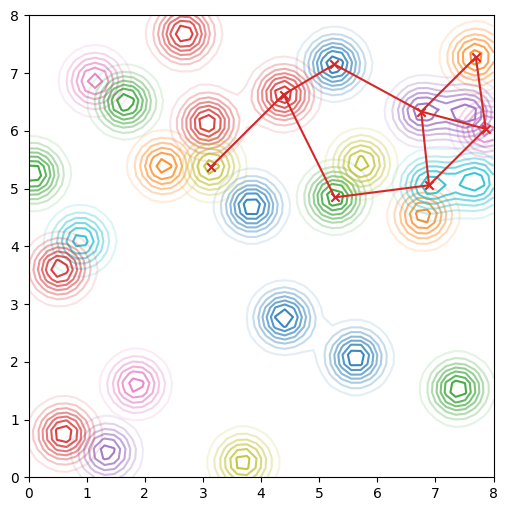

In [4]:
# Create Observation
NUM_OBS_RNG = [2, 5]

# Create some random components to add to the node observations.
num_obs = [np.random.randint(*NUM_OBS_RNG) for _ in range(N)]
means = [np.random.uniform(*LIMS[:2], (n, 2)) for n in num_obs]
# Add the true value to each observation.
means = [np.concatenate([m, np.expand_dims(s, 0)]) for m, s in zip(means, robots.pos)]
sigs = [[OBS_SIGMA * np.eye(2) for _ in range(n + 1)] for n in num_obs]
obs = [dist.Mixture(m, sig) for m, sig in zip(means, sigs)]

# The unary factor will use a Distribution object to compute the likelihood.
unary_factors = [factors.DistributionUnaryFactor(obs[i]) for i in range(g.N)]
# Recreate the graph now that we have defined unary factors.
g = MRFGraph(N, robots.edges, edge_factors=edge_factors, unary_factors=unary_factors)

# Visualize the final problem with the noisy, multi-modal observations.
plt.figure(figsize=(6, 6))
plot_dists(plt.gca(), obs, LIMS)
plot_graph(plt.gca(), robots.pos, g)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## Baseline: Particle Belief Propagation

This is the baseline implementation.

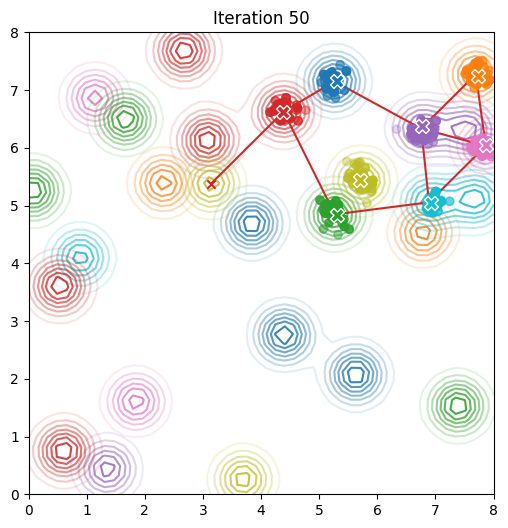

In [5]:
K = 50               # Number of particles.
ITERS = 50           # Number of iterations to run.
JITTER = 0.05        # Jitter to apply to particles before resampling.
MSG_PASS_ITERS = 5   # Number of message passing iterations to run.
COMPUTE_MLE = True   # If True, will draw the Maximum Likelihood Estimate.
# Images will be saved here.
OUTPUT_DIR = "../output/robot_loc/pbp"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Uniformly initialize the particles in the environment.
init_particles = torch.Tensor(N, K, 2).uniform_(*LIMS[:2])
pbp = bp.LoopyParticleBP(init_particles, g)

# Intermediate plotting function, called to plot particles at each iteration.
def plot_intermediate(solver, it, compute_mle=COMPUTE_MLE):
    mles = [] if compute_mle else None
    weights = [] if compute_mle else None
    if compute_mle:
        for s in range(solver.graph.N):
            w = solver.compute_belief_weights(s)
            x_s = solver.particles(s)[w.argmax(), :].numpy()
            mles.append(x_s)
            weights.append(w.detach())
        weights = torch.stack(weights)

    plt.figure(0, figsize=(6, 6))
    plt.cla()
    plt.clf()
    plt.title(f"Iteration {it + 1}")
    plot_particles(plt.gca(), solver.particles(), robots.pos, graph=solver.graph,
                   dists=obs, weights=weights, mle=mles, lims=LIMS)

    plt.savefig(os.path.join(OUTPUT_DIR, f"iteration_{(it + 1):03}.jpg"))


# Plot the initial iteration.
plot_intermediate(pbp, -1, compute_mle=False)

# Solve the PBP problem.
particles = pbp.solve(num_iters=ITERS, msg_pass_per_iter=MSG_PASS_ITERS,
                      jitter_sigma=JITTER, iter_fn=plot_intermediate)

## SVBP

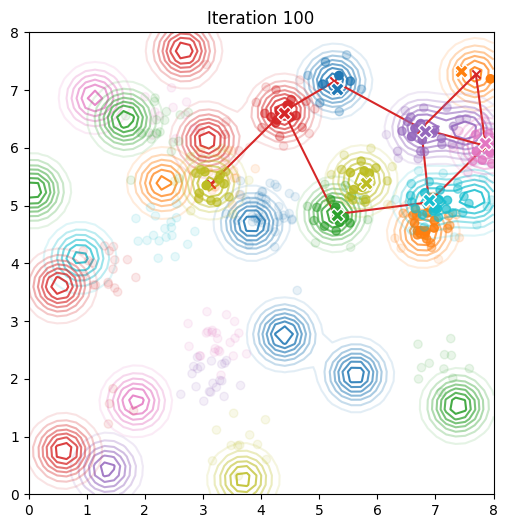

In [6]:
K = 50               # Number of particles.
LR = 0.1             # Learning rate for the optimizer.
ITERS = 100          # Number of iterations to run.
MSG_PASS_ITERS = 5   # Number of message passing iterations to run.
COMPUTE_MLE = True   # If True, will draw the Maximum Likelihood Estimate.
# Images will be saved here.
OUTPUT_DIR = "../output/robot_loc/svbp"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Create the kernel and the optimization parameters.
rbf_kernel = RBFMedianKernel(sigma=0.5)
optim_type = torch.optim.Adam           # optimizer type
optim_params = {'lr': LR}               # optimizer params

# Uniformly initialize the particles in the environment.
init_particles = torch.Tensor(N, K, 2).uniform_(*LIMS[:2])
svbp = bp.LoopySVBP(init_particles, g, rbf_kernel, optim_type=optim_type, optim_kwargs=optim_params)

# Plot the initial iteration.
plot_intermediate(svbp, -1, compute_mle=False)

# Solve the SVBP problem
particles = svbp.solve(num_iters=ITERS, msg_pass_per_iter=MSG_PASS_ITERS, iter_fn=plot_intermediate)